In [ ]:
# Load gemini
from context import gemini
from gemini  import data, engine, helpers

# Global Imports
import pandas as pd
import numpy as np

# Build mean reversion strategy
from talib.abstract import *

In [2]:
def bands(df, timeperiod=26, nbdevup=2.6, nbdevdn=2.6, matype=0):
    cols = ['high', 'low', 'open', 'close', 'volume']
    HLOCV = {key: df[key].values for key in df if key in cols}
    u, m, l = BBANDS(HLOCV, timeperiod=timeperiod, nbdevup=nbdevup, nbdevdn=nbdevdn, matype=matype)
    df['upper']  = u
    df['middle'] = m
    df['lower']  = l
    return df

def touches(df):
    df['touch_upper'] = df.high >= df.upper
    df['touch_lower'] = df.low  <= df.lower
    df['crossing_dn'] = (df.close < df.middle) & (df.open > df.middle)
    df['crossing_up'] = (df.close > df.middle) & (df.open < df.middle)
    return df

In [3]:
def logic(account, lookback):
    try:
        lookback = helpers.period(lookback)
        today = lookback.loc(0)
        
        # Selling
        if today.touch_upper:
            exit_price = today.upper
            for position in account.positions:  
                if position.type == 'long':
                    account.close_position(position, 1, exit_price)

        if today.crossing_up:
            exit_price = today.close
            for position in account.positions:  
                if position.type == 'long':
                    account.close_position(position, 1, exit_price)
                    
        # Buying
        if today.touch_lower | today.crossing_dn:
            risk          = 1
            entry_price   = today.lower
            entry_capital = account.buying_power*risk
            if entry_capital > 0:
                account.enter_position('long', entry_capital, entry_price)
     
        if today.crossing_dn:
            risk          = 1
            entry_price   = today.close
            entry_capital = account.buying_power*risk
            if entry_capital > 0:
                account.enter_position('long', entry_capital, entry_price)    
    
    except Exception as e:
        print(e)
        pass # Handles lookback errors in beginning of dataset

In [4]:
# Apply strategy to example
df = pd.read_csv("data/BTC_USD.csv", header=0, index_col=0)
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,low,high,open,close,volume
0,2017-02-15 16:00:00,1009.70000399,1018.00000000,1010.09990931,1014.83589839,225268.43507453
1,2017-02-16 00:00:00,1011.60000000,1032.13660417,1011.60000000,1021.75360065,316925.44590378
2,2017-02-16 08:00:00,1021.75360206,1039.95700000,1024.70000000,1035.00000000,215385.30718065
3,2017-02-16 16:00:00,1033.50000001,1045.00000000,1035.00000000,1039.49925987,431951.93722578
4,2017-02-17 00:00:00,1035.50000000,1044.99999989,1039.49925949,1043.99999999,162001.23700635


In [5]:
df = bands(df)
df = touches(df)

In [6]:
backtest = engine.backtest(df)

In [7]:
output = backtest.start(1000, logic)
output.tail()

,benchmark_equity,strategy_equity,benchmark_return,strategy_return
date,,,,
2017-10-30 16:00:00,6125.00000000,39117.46414278,0.00744468,0.00000000
2017-10-31 00:00:00,6106.99999987,39117.46414278,-0.00293878,0.00000000
2017-10-31 08:00:00,6355.00000010,39117.46414278,0.04060914,0.00000000
2017-10-31 16:00:00,6450.02162843,39117.46414278,0.01495226,0.00000000
2017-11-01 00:00:00,6405.52060937,39117.46414278,-0.00689936,0.00000000


In [8]:
backtest.results()

-------------- Results ----------------

Buy and Hold : 534.15%
Net Profit   : 5341.47
Strategy     : 3811.75%
Net Profit   : 38117.46
Longs        : 30
sells        : 31
shorts       : 0
covers       : 0
--------------------
Total Trades : 61

---------------------------------------


### Feed results into Pyfolio analysis

In [10]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

Start date,2017-02-15
End date,2017-11-01
Total months,36
,Backtest
Annual return,228.9%
Cumulative returns,3811.7%
Annual volatility,47.9%
Sharpe ratio,2.72
Calmar ratio,9.38
Stability,0.96
Max drawdown,-24.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.42,2017-09-12,2017-09-15,2017-09-21,8
1,23.89,2017-07-10,2017-07-16,2017-07-20,9
2,19.66,2017-06-13,2017-06-15,2017-06-25,9
3,18.51,2017-03-17,2017-03-25,2017-04-16,20
4,9.61,2017-05-28,2017-05-28,2017-05-29,1


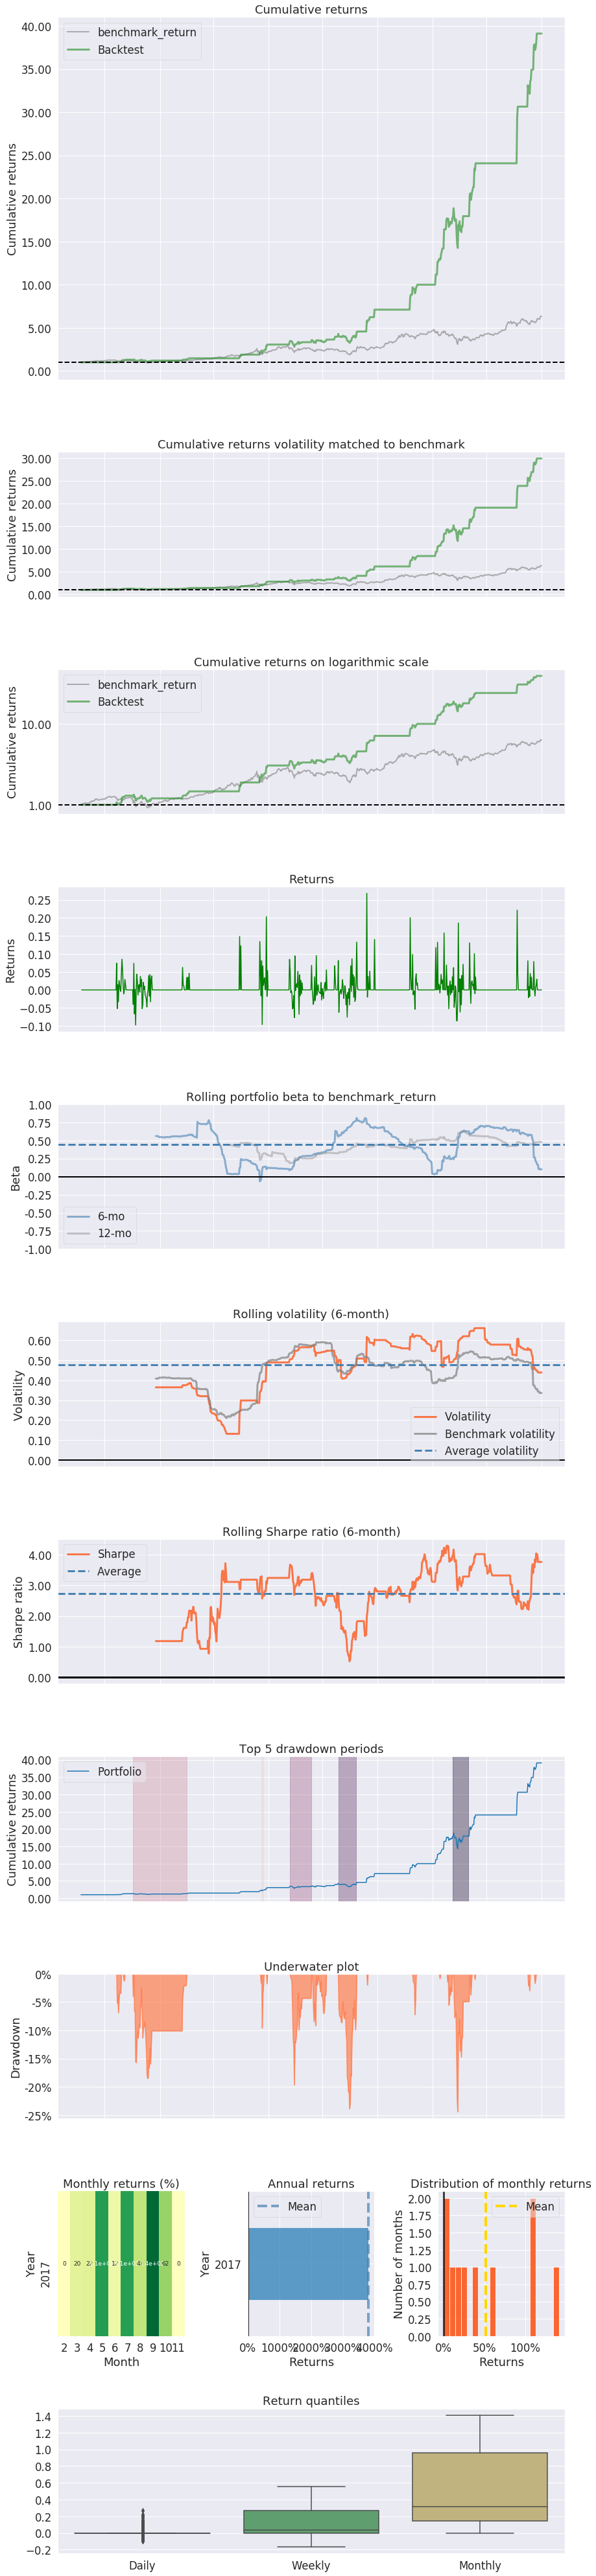

In [11]:
pf.create_returns_tear_sheet(output['strategy_return'], benchmark_rets=output['benchmark_return'])